<a href="https://colab.research.google.com/github/ketanhdoshi/ml/blob/master/examples/Tensorflow_Estimator_Airbnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Complete example using Estimators and airbnb data set to predict rental prices

Example of using Estimators, Feature Columns and Input Functions. It also shows how to process input data using Pandas and Dataframes.

Based on  this article - https://medium.com/learning-machine-learning/introduction-to-tensorflow-estimators-part-1-39f9eb666bc7


In [ ]:
import tensorflow as tf
print(tf.__version__)

1.12.0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-colorblind")
%matplotlib inline
# only displays the most important warnings
tf.logging.set_verbosity(tf.logging.FATAL)

### Load the data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dummy_listings.csv to dummy_listings.csv


In [ ]:
!ls

dummy_listings.csv  sample_data


In [ ]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "dummy_listings.csv" with length 905 bytes


In [ ]:
import io
boston = pd.read_csv(io.StringIO(uploaded['dummy_listings.csv'].decode('utf-8')))

In [ ]:

used_features = ['property_type','room_type','bathrooms','bedrooms','beds','bed_type','accommodates','host_total_listings_count'
                ,'number_of_reviews','review_scores_value','neighbourhood_cleansed','cleaning_fee','minimum_nights','security_deposit','host_is_superhost',
                 'instant_bookable', 'price']
#boston = pd.read_csv(uploaded['dummy_listings.csv'], usecols = used_features)
print(boston.shape)
boston.head(2)

(7, 18)


,id,property_type,room_type,bathrooms,bedrooms,beds,bed_typ,accommodates,host_total_listings_count,number_of_reviews,review_scores_value,neighbourhood_cleansed,cleaning_fee,minimum_nights,security_deposit,host_is_superhost,instant_bookable,price
0,3781,House,Entire home/apt,2.0,3.0,1.5,Real Bed,3,7,14,3.7,East Boston,125,30,320,False,True,125
1,5506,Apartment,Entire home/apt,2.5,4.0,2.0,Real Bed,3,7,75,4.1,Roxbury,125,3,320,False,True,145


### Pre-Process data

In [ ]:
for feature in ["cleaning_fee","security_deposit","price"]:
    boston[feature] = boston[feature].map(lambda x:x.replace("$",'').replace(",",''),na_action = 'ignore')
    boston[feature] = boston[feature].astype(float)
    boston[feature].fillna(boston[feature].median(),inplace = True)
    
    
for feature in ["bathrooms","bedrooms","beds","review_scores_value"]:
    boston[feature].fillna(boston[feature].median(),inplace = True)
    
boston['property_type'].fillna('Apartment',inplace = True)

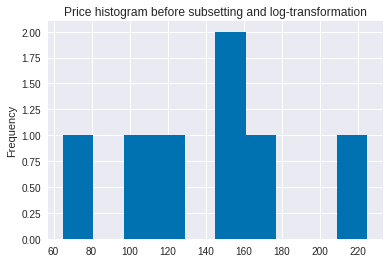

In [ ]:
boston["price"].plot(kind = 'hist',grid = True)
plt.title("Price histogram before subsetting and log-transformation");

In [ ]:
boston['price'].skew()

0.23039971176893448

### Prepare Target data
We can also see most of the data falls under 500. So we’ll use a subset of our dataset where the price ranges from 50–500 for now to remove very large and very small prices. We’ll also log-transform the target variable to reduce skewness.

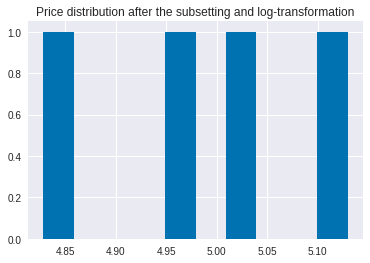

In [ ]:
#boston = boston[(boston["price"]>50)&(boston["price"]<500)]
boston = boston[(boston["price"]>100)&(boston["price"]<180)]
target = np.log(boston.price)
target.hist()
plt.title("Price distribution after the subsetting and log-transformation");

### Prepare Features data

In [ ]:
features = boston.drop('price',axis=1)
features.head()

,id,property_type,room_type,bathrooms,bedrooms,beds,bed_typ,accommodates,host_total_listings_count,number_of_reviews,review_scores_value,neighbourhood_cleansed,cleaning_fee,minimum_nights,security_deposit,host_is_superhost,instant_bookable
0,3781,House,Entire home/apt,2.0,3.0,1.5,Real Bed,3,7,14,3.7,East Boston,125,30,320,False,True
1,5506,Apartment,Entire home/apt,2.5,4.0,2.0,Real Bed,3,7,75,4.1,Roxbury,125,3,320,False,True
2,6695,House,Entire home/apt,2.5,4.0,2.0,Real Bed,3,5,77,4.4,Roxbury,165,3,270,False,False
5,8792,Apartment,Entire home/apt,2.5,3.5,2.5,Real Bed,4,6,24,3.9,Downtown,140,20,410,False,True


### Split the data into train and test set

In [ ]:
# scikit's train_test_split accepts the features and the target as parameters and returns the randomly shuffled data. We have set 33% of the data in the test set and the rest are in training set. 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
     features, target, test_size=0.33, random_state=42)

### Define Feature Columns

In [ ]:
# First separate the column names of the numeric features and the categorical features
# Get all the numeric feature names
numeric_columns = ['host_total_listings_count','accommodates','bathrooms','bedrooms','beds',
 'security_deposit','cleaning_fee','minimum_nights','number_of_reviews',
 'review_scores_value']

# Get all the categorical feature names that contains strings
#categorical_columns = ['host_is_superhost','neighbourhood_cleansed','property_type','room_type','bed_type','instant_bookable']
categorical_columns = ['neighbourhood_cleansed','property_type','room_type']

In [ ]:
# create numeric_columns for all the numeric features
numeric_features = [tf.feature_column.numeric_column(key = column) for column in numeric_columns]
print(numeric_features[0])

_NumericColumn(key='host_total_listings_count', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)


In [ ]:
# create the categorical features
categorical_features = [tf.feature_column.categorical_column_with_vocabulary_list(key = column, 
                                                                                 vocabulary_list = features[column].unique()) 
                                                                                for column in categorical_columns]
print(categorical_features[1])

_VocabularyListCategoricalColumn(key='property_type', vocabulary_list=('House', 'Apartment'), dtype=tf.string, default_value=-1, num_oov_buckets=0)


In [ ]:
# combine all the numeric and the categorical feature columns so that we can pass it to our canned estimator.
linear_features = numeric_features + categorical_features

### Input Function

In [ ]:
# Create training input function
training_input_fn = tf.estimator.inputs.pandas_input_fn(x = X_train,
                                                        y=y_train,
                                                        batch_size=32,
                                                        shuffle= True,
                                                        num_epochs = None)

# create testing input function
eval_input_fn = tf.estimator.inputs.pandas_input_fn(x=X_test,
                                                    y=y_test,
                                                    batch_size=32,
                                                    shuffle=False,
                                                    num_epochs = 1)

### Instantiate the Model

In [ ]:
# model_dir parameter is where tensorflow will store the model graph for visualisation with tensorboard
linear_regressor = tf.estimator.LinearRegressor(feature_columns=linear_features,
                                                model_dir = "linear_regressor")

### Train the Model

In [ ]:
linear_regressor.train(input_fn = training_input_fn,steps=2000)

### Evaluate the Model

In [ ]:
# returns a dict containing loss after evaluating the model on the test set. Default loss is defined as mean squared error(MSE) in the LinearRegressor model.
linear_regressor.evaluate(input_fn = eval_input_fn)
#print("Loss is " + str(loss))

{'average_loss': 0.33788007,
 'global_step': 2000,
 'label/mean': 5.006843,
 'loss': 0.67576015,
 'prediction/mean': 5.5157967}

### Make Predictions

In [ ]:
# LinearRegressor.predict method returns a generator for yielding predictions. Since we have set the num_epoch to 1 the input function 
# will feed the test dataset only once to the evaluation function
pred = list(linear_regressor.predict(input_fn = eval_input_fn))
pred = [p['predictions'][0] for p in pred]

# Use exp to inverse the price since we had log-transformed it earlier
prices = np.exp(pred)
print(prices)

[182.16096 339.23807]


### Visualise Feature Weights

In [ ]:
# find the variable names for each feature from the model by using the get_variable_names method first, so we can later get the weights by using those names. 
linear_regressor.get_variable_names()

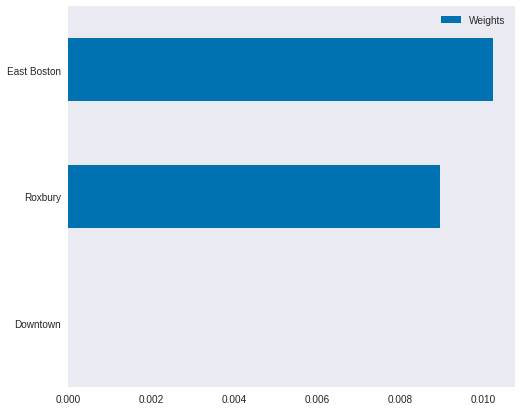

In [ ]:
# get the feature weights for the neighbourhood_cleansed categorical feature and store them in property_weights. 
property_weights = linear_regressor.get_variable_value('linear/linear_model/neighbourhood_cleansed/weights').flatten()
property_keys = boston["neighbourhood_cleansed"].value_counts().keys()

# Create a Dataframe with the feature weights as values and the different neighborhood names as index
pd.DataFrame({"Weights":property_weights},index=property_keys).sort_values("Weights",ascending=True).plot(kind="barh", 
                                                                                                          figsize= (8,7), 
                                                                                                          grid = False
                                                                                                         );

## Visualise with Tensorboard

**To view Tensorboard output locally, use ngrok to tunnel traffic to localhost. First, download and unzip ngrok on the Colab server**

In [ ]:
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip

--2018-12-03 09:36:18--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.204.188.97, 34.196.237.103, 35.173.3.255, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.204.188.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  9.82MB/s    in 0.5s    

2018-12-03 09:36:24 (9.82 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


**Get TensorBoard running in the background**

In [ ]:
LOG_DIR = 'linear_regressor'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

**Launch ngrok background process**

In [ ]:
get_ipython().system_raw('./ngrok http 6006 &')

**We get the public URL where we can access the colab TensorBoard web page. This will output a URL you can click on**

In [ ]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://418594a1.ngrok.io
